# Run pancreas benchmark on Seurat reference mapping

Follow steps from https://satijalab.org/seurat/v3.2/integration.html

In [7]:
## Imports
suppressPackageStartupMessages({
    library(Seurat)
    library(uwot)
    library(matrixStats)
    
    # for figures
    library(ggplot2)
    library(ggthemes)
    library(RColorBrewer)
    library(patchwork)
})

fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}

# Load pancreas data

In [3]:
exprs_norm = readRDS('../../data/Fig4_pancreas_multi/reference_four_exp.rds')
metadata = readRDS('../../data/Fig4_pancreas_multi/reference_four_metadata.rds')

In [4]:
metadata$batch <- as.character(metadata$batch)
table(metadata$dataset)


      c1   celseq  celseq2 smartseq 
     625      946     2238     2078 

In [5]:
## Restrict to the top variable genes so results are consistent between tools
vargenestouse = read.csv('../../data/Fig4_pancreas_multi/reference_top1000perdataset_total2236_vargenes.csv')

In [6]:
system.time({

exprs_norm_vargenes = exprs_norm[vargenestouse$symbol, ]
panc_ref <- CreateSeuratObject(counts = exprs_norm_vargenes, project = "panc_ref")

panc_ref@meta.data$donor <- metadata$donor
panc_ref@meta.data$dataset <- metadata$dataset
panc_ref@meta.data$batch <- metadata$batch
panc_ref@meta.data$cell_type <- metadata$cell_type
panc_ref@meta.data$cell_subtype <- metadata$cell_subtype
panc_ref@meta.data$donor <- as.character(panc_ref@meta.data$donor)

# If seperate by donor, got an Error at "IntegrateData" in idx[i, ] <- res[[i]][[1]]: 
# number of items to replace is not a multiple of replacement length
# This could be caused by some donors have really small number of cells (say 57 from AZ)?
pancreas.list <- SplitObject(panc_ref, split.by = "dataset") 

for (i in 1:length(pancreas.list)) {
    # data already log normalized
    VariableFeatures(pancreas.list[[i]]) = vargenestouse$symbol ## Set variable features
}
    
# Next, we identify anchors using the FindIntegrationAnchors function, 
# which takes a list of Seurat objects as input.
set.seed(0)
pancreas.anchors <- FindIntegrationAnchors(object.list = pancreas.list, dims = 1:20, 
                                           anchor.features = 2236, verbose = FALSE)

set.seed(0)
pancreas.integrated <- IntegrateData(anchorset = pancreas.anchors, dims = 1:20, verbose = FALSE) # default is 30

DefaultAssay(pancreas.integrated) <- "integrated"
    
})

   user  system elapsed 
 76.180  52.375  65.414 

In [9]:
# Run the standard workflow for visualization and clustering
set.seed(0)
system.time({
    pancreas.integrated = ScaleData(pancreas.integrated, verbose = FALSE)
    pancreas.integrated = RunPCA(pancreas.integrated, npcs = 20, verbose = FALSE)
    pancreas.integrated = RunUMAP(pancreas.integrated, reduction = "pca", dims = 1:20, verbose = FALSE)    
})

   user  system elapsed 
 31.419   5.992  22.877 

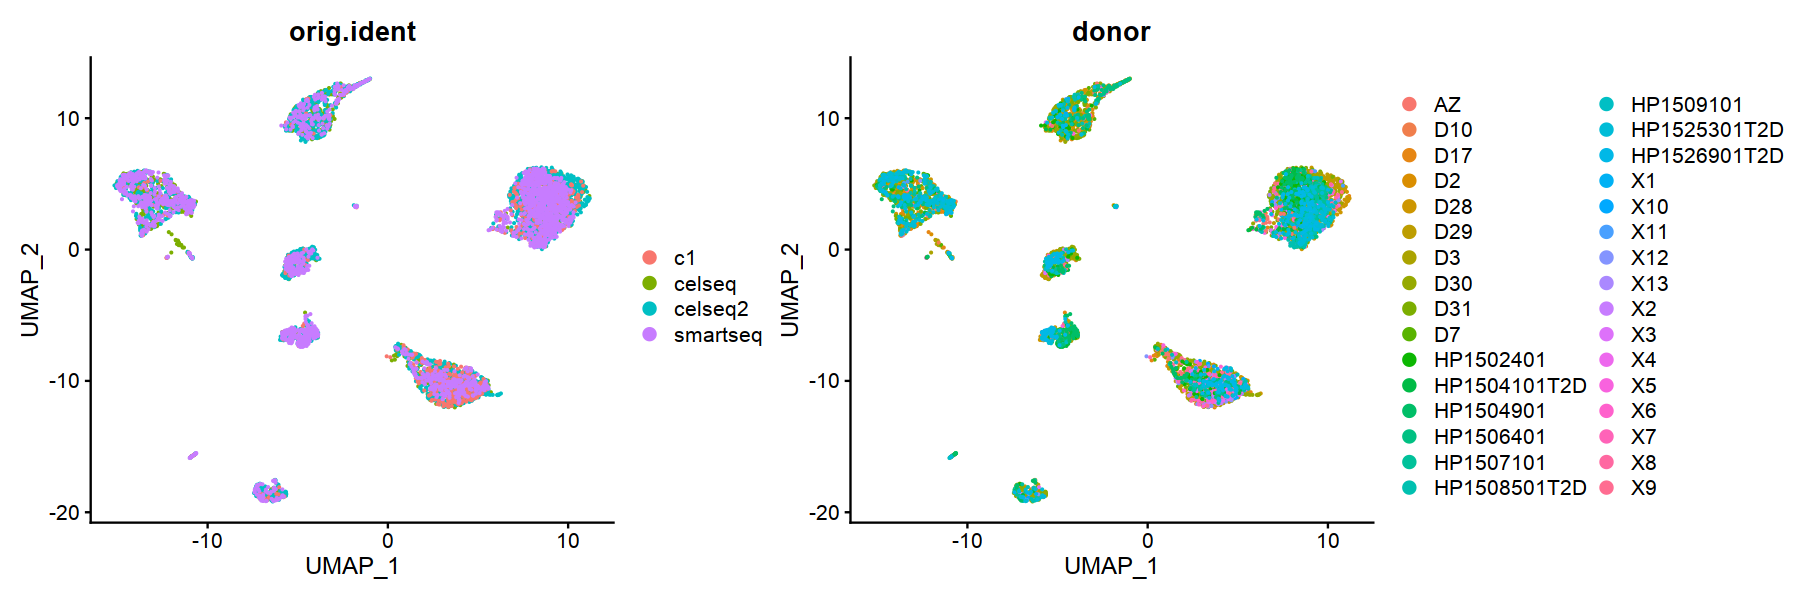

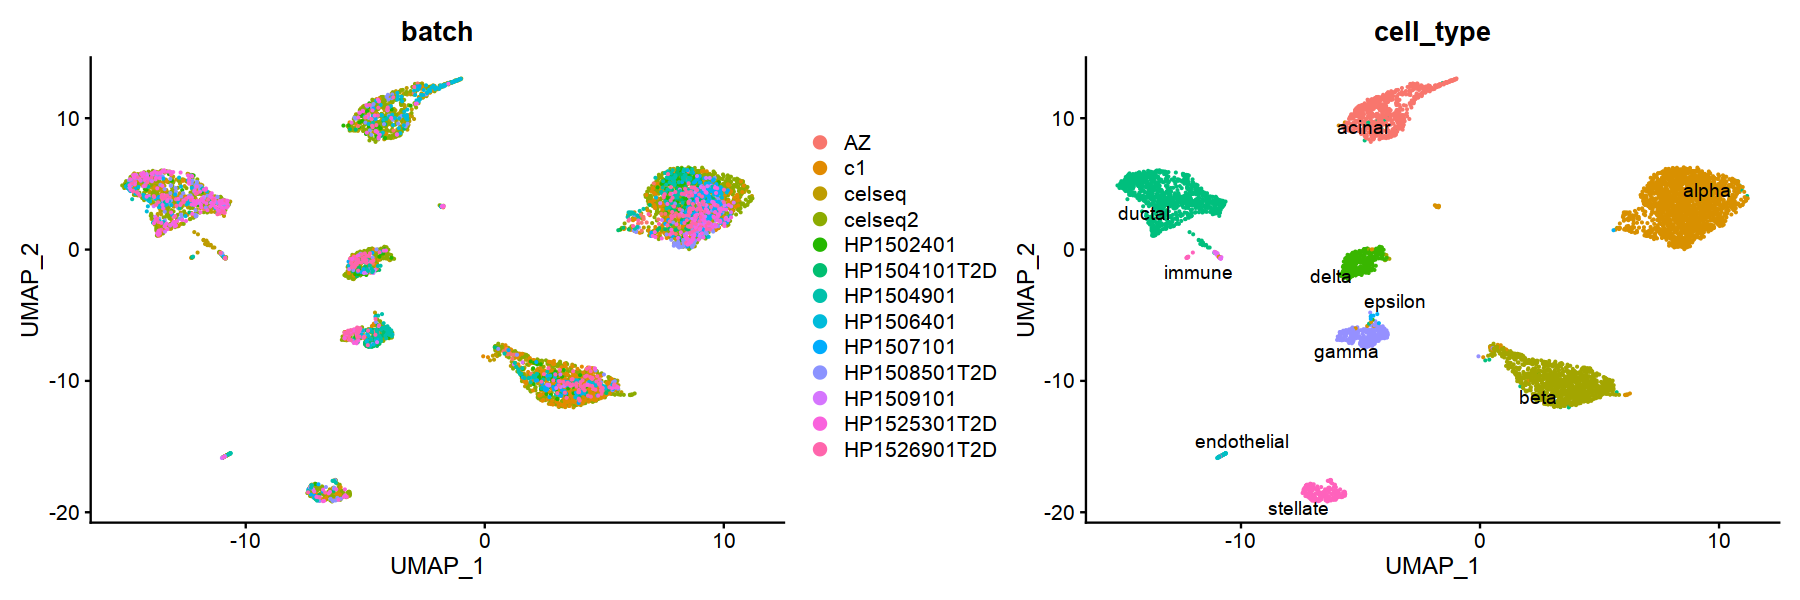

In [10]:
options(repr.plot.height = 5, repr.plot.width = 15)
p1 <- DimPlot(pancreas.integrated, reduction = "umap", group.by = "orig.ident", pt.size = 0.1)
p2 <- DimPlot(pancreas.integrated, reduction = "umap", group.by = "donor", pt.size = 0.1)
p3 <- DimPlot(pancreas.integrated, reduction = "umap", group.by = "batch", pt.size = 0.1)
p4 <- DimPlot(pancreas.integrated, reduction = "umap", group.by = "cell_type", pt.size = 0.1, label = TRUE, 
    repel = TRUE) + NoLegend()
p1 + p2 
p3 + p4

In [11]:
saveRDS(pancreas.integrated, "Seurat_reference_obj.rds")

In [12]:
# Load reference
pancreas.integrated <- readRDS("Seurat_reference_obj.rds")
pancreas.integrated@reductions

$pca
A dimensional reduction object with key PC_ 
 Number of dimensions: 20 
 Projected dimensional reduction calculated:  FALSE 
 Jackstraw run: FALSE 
 Computed using assay: integrated 

$umap
A dimensional reduction object with key UMAP_ 
 Number of dimensions: 2 
 Projected dimensional reduction calculated:  FALSE 
 Jackstraw run: FALSE 
 Computed using assay: integrated 


# Map Baron human query

In [13]:
# Query is human
query_exprs_norm = readRDS("../../data/Fig4_pancreas_multi/baron_human_exp.rds")
query_metadata = readRDS("../../data/Fig4_pancreas_multi/baron_human_metadata.rds")
all(query_metadata$cell_id == colnames(query_exprs_norm))

[1] TRUE

In [14]:
query_metadata$donor = as.character(query_metadata$donor)
dim(query_exprs_norm)
max(query_exprs_norm)

[1] 20125  8569

[1] 8.725244

In [15]:
table(query_metadata$donor)
table(query_metadata$cell_type)
table(query_metadata$cell_type1)


   1    2    3    4 
1937 1724 3605 1303 


     acinar       alpha        beta       delta      ductal endothelial 
        958        2326        2525         601        1077         252 
    epsilon       gamma      immune     schwann    stellate 
         18         255          87          13         457 


            acinar activated_stellate              alpha               beta 
               958                284               2326               2525 
             delta             ductal        endothelial            epsilon 
               601               1077                252                 18 
             gamma         macrophage               mast quiescent_stellate 
               255                 55                 25                173 
           schwann             t_cell 
                13                  7 

In [16]:
system.time({
    
query_exprs_norm_vargenes = query_exprs_norm[vargenestouse$symbol, ]

panc_query = CreateSeuratObject(counts = query_exprs_norm_vargenes, project = "panc_query")
    
panc_query@meta.data$donor <- query_metadata$donor
panc_query@meta.data$donor <- as.character(panc_query@meta.data$donor)
panc_query@meta.data$dataset <- query_metadata$dataset
panc_query@meta.data$cell_type <- query_metadata$cell_type
panc_query@meta.data$cell_subtype <- query_metadata$cell_type1

VariableFeatures(panc_query) = vargenestouse$symbol

panc_query.batches <- SplitObject(panc_query, split.by = "orig.ident") 

# query was log(CP10K +1) normalized as well

})

   user  system elapsed 
  0.689   0.001   0.690 

In [19]:
# We then find anchors between each donor query dataset and the multimodal reference. 
# This command is optimized to minimize mapping time, by passing in a pre-computed set of 
# reference neighbors, and turning off anchor filtration.

# Function: https://rdrr.io/cran/Seurat/man/FindTransferAnchors.html
# Perform dimensional reduction. Exactly what is done here depends on the values set for the reduction and project.query parameters. 
# If reduction = "pcaproject", a PCA is performed on either the reference (if project.query = FALSE) or the query (if project.query = TRUE), 
# using the features specified. The data from the other dataset is then projected onto this learned PCA structure. 
# If reduction = "cca", then CCA is performed on the reference and query for this dimensional reduction step. 
# If l2.norm is set to TRUE, perform L2 normalization of the embedding vectors.
set.seed(0)
system.time({
    anchors <- list()
    for (i in 1:length(panc_query.batches)) {
      anchors[[i]] <- FindTransferAnchors(
                            reference = pancreas.integrated,
                            query = panc_query.batches[[i]],
                            k.filter = NA,
                            reduction = "pcaproject",       # either pcaproject or cca: only two options
                            reference.reduction = "pca", # spca is for ADT and mRNA
                        # reference.neighbors = "spca.annoy.neighbors", 
                            dims = 1:20,    # npc is smaller than defaut 50, so set it to 20
                            verbose = FALSE
      )
    }
    
    # Individually map each of the datasets.
    for (i in 1:length(panc_query.batches)) {
      panc_query.batches[[i]] <- MapQuery(
        anchorset = anchors[[i]], 
        query = panc_query.batches[[i]],
        reference = pancreas.integrated, 
        refdata = list(
          cell_type = "cell_type"),
    #     reduction = "umap" # 
        reference.reduction = "pca", # Tried to set this to "pca" or "umap", but just give me pca embeddings
    #     reduction.model = "umap"  # setting "umap" caused this step run forever ...
          verbose = FALSE
      )
    }
})

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from predictionscorecell_type_ to predictionscorecelltype_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from ref.pca_ to refpca_”
Warning message:
“UNRELIABLE VALUE: Future (‘future_lapply-1’) unexpectedly generated random numbers without specifying argument 'future.seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from ref.pca_ to refpca_”
Warning message:
“All keys should be one or more alphanumeric characters

   user  system elapsed 
 31.579   9.738  31.425 

In [20]:
panc_query.batches$human2@reductions

$ref.pca
A dimensional reduction object with key refpca_ 
 Number of dimensions: 20 
 Projected dimensional reduction calculated:  FALSE 
 Jackstraw run: FALSE 
 Computed using assay: RNA 


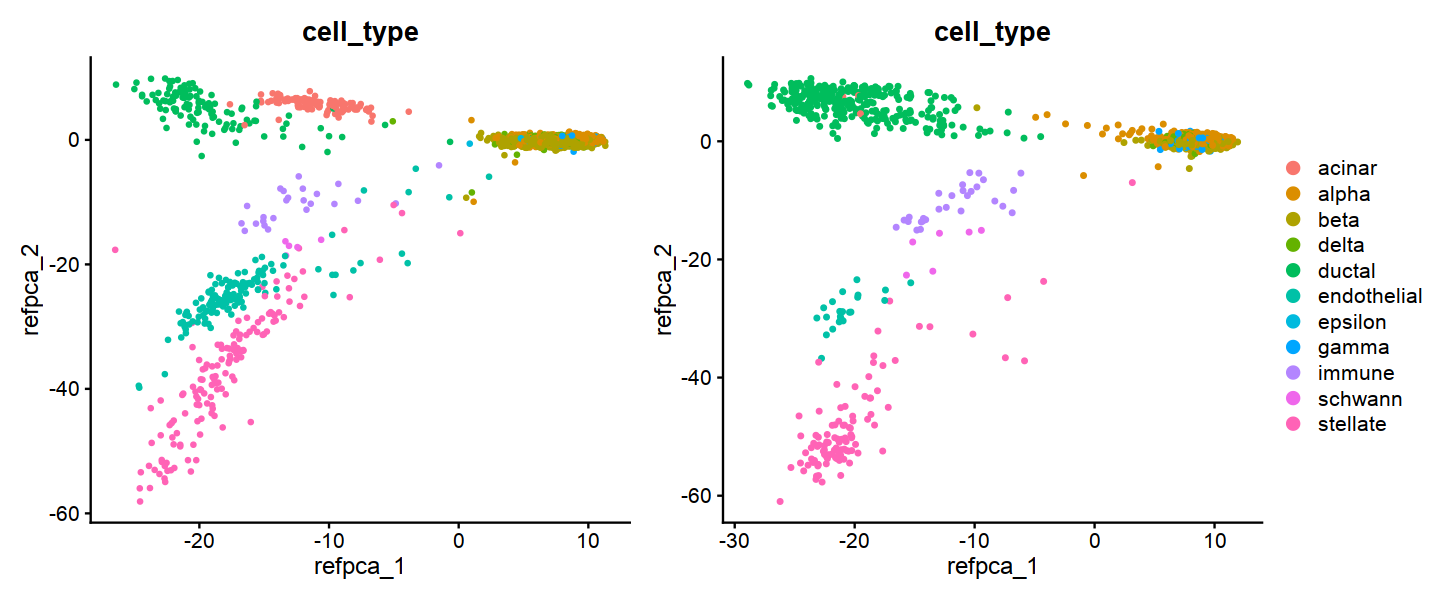

In [21]:
# Now that mapping is complete, we can visualize the results for individual objects

options(repr.plot.height = 5, repr.plot.width = 12)
p1 <- DimPlot(panc_query.batches[[1]], reduction = 'ref.pca', group.by = 'cell_type', label.size = 3)
p2 <- DimPlot(panc_query.batches[[2]], reduction = 'ref.pca', group.by = 'cell_type', label.size = 3)
p1 + p2 + plot_layout(guides = "collect")

In [22]:
# Merge the batches 
panc_query <- merge(panc_query.batches[[1]], panc_query.batches[2:length(panc_query.batches)], merge.dr = "ref.pca")

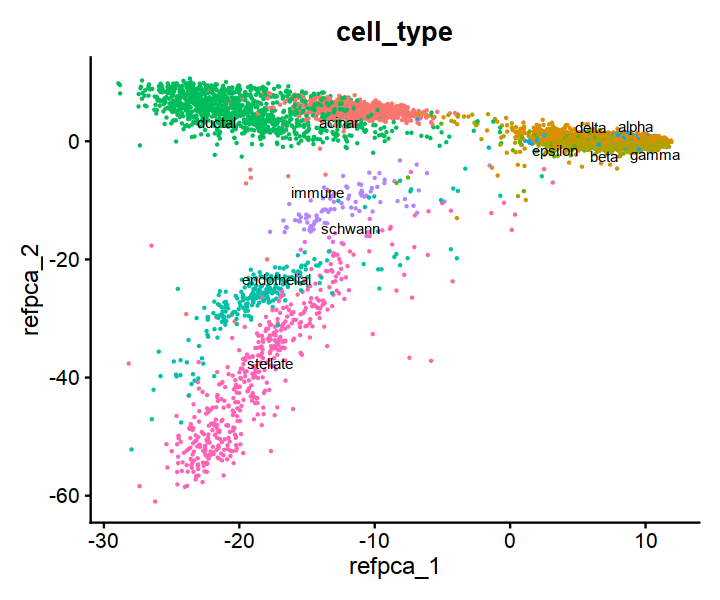

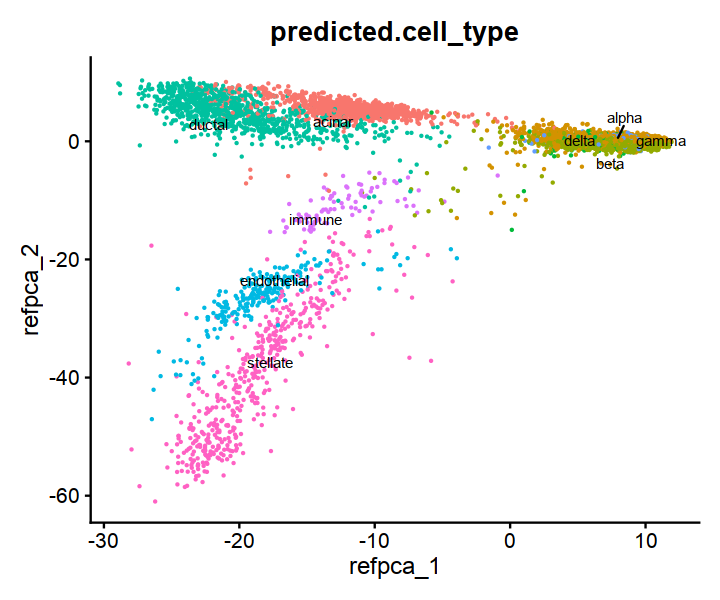

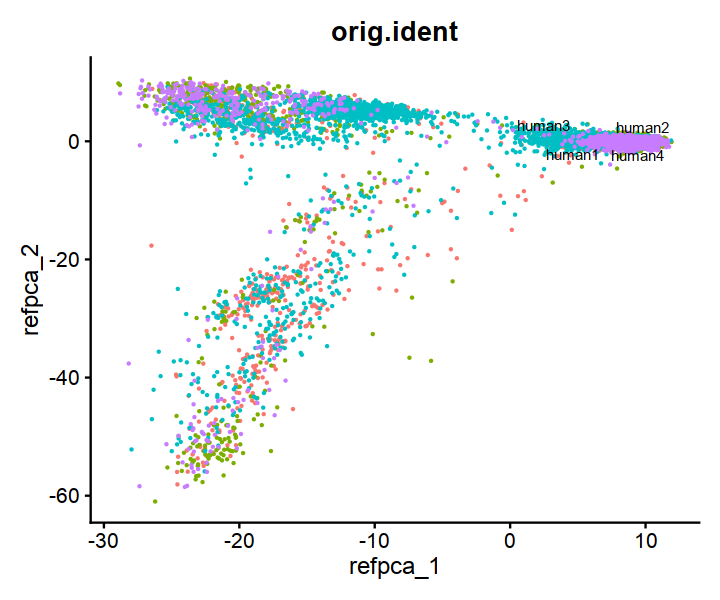

In [23]:
options(repr.plot.height = 5, repr.plot.width = 6)
DimPlot(panc_query, reduction = "ref.pca", group.by =  "cell_type", label = TRUE, repel = TRUE, label.size = 3) + NoLegend()
DimPlot(panc_query, reduction = "ref.pca", group.by =  "predicted.cell_type", label = TRUE, repel = TRUE, label.size = 3) + NoLegend()
DimPlot(panc_query, reduction = "ref.pca", group.by =  "orig.ident", label = TRUE, repel = TRUE, label.size = 3) + NoLegend()

In [24]:
panc_query@reductions

$ref.pca
A dimensional reduction object with key refpca_ 
 Number of dimensions: 20 
 Projected dimensional reduction calculated:  FALSE 
 Jackstraw run: FALSE 
 Computed using assay: RNA 


In [25]:
# PCs can be loaded here
class(panc_query@reductions$ref.pca)
dim(panc_query@reductions$ref.pca)

[1] "DimReduc"
attr(,"package")
[1] "SeuratObject"

[1] 8569   20

In [26]:
saveRDS(panc_query, "Seurat_query_human_obj.rds")

# Map Baron mouse query

In [27]:
# Query is mouse
query_exprs_norm <- readRDS('../../data/Fig4_pancreas_multi/baron_mouse_biomart_homologene_exp.rds')
query_metadata <- readRDS("../../data/Fig4_pancreas_multi/baron_mouse_metadata.rds")
all(query_metadata$cell_id == colnames(query_exprs_norm))

[1] TRUE

In [28]:
idx_to_keep = rownames(query_exprs_norm) %in% vargenestouse$symbol
query_ref_vargenes = rownames(query_exprs_norm)[idx_to_keep]

query_exprs_norm_vargenes = query_exprs_norm[idx_to_keep, ]
dim(query_exprs_norm_vargenes)

[1] 1874 1886

In [29]:
query_metadata$donor = as.character(query_metadata$donor)
dim(query_exprs_norm)

[1] 20873  1886

In [30]:
table(query_metadata$donor)
table(query_metadata$cell_type)
table(query_metadata$cell_type1)


   1    2 
 822 1064 


      alpha        beta       delta      ductal endothelial       gamma 
        191         894         218         275         139          41 
     immune     schwann    stellate 
         61           6          61 


activated_stellate              alpha             B_cell               beta 
                14                191                 10                894 
             delta             ductal        endothelial              gamma 
               218                275                139                 41 
      immune_other         macrophage quiescent_stellate            schwann 
                 8                 36                 47                  6 
            T_cell 
                 7 

In [31]:
panc_query <- CreateSeuratObject(counts = query_exprs_norm_vargenes, project = "panc_query")
panc_query

An object of class Seurat 
1874 features across 1886 samples within 1 assay 
Active assay: RNA (1874 features, 0 variable features)

In [32]:
VariableFeatures(panc_query) = query_ref_vargenes

In [33]:
panc_query@meta.data$donor <- query_metadata$donor
panc_query@meta.data$donor <- as.character(panc_query@meta.data$donor)
panc_query@meta.data$dataset <- query_metadata$dataset
panc_query@meta.data$cell_type <- query_metadata$cell_type
panc_query@meta.data$cell_subtype <- query_metadata$cell_type1
table(panc_query$orig.ident)
table(panc_query@meta.data$donor)


mouse1 mouse2 
   822   1064 


   1    2 
 822 1064 

In [34]:
panc_query.batches <- SplitObject(panc_query, split.by = "orig.ident")

In [35]:
set.seed(0)
system.time({
    anchors <- list()
    for (i in 1:length(panc_query.batches)) {
      anchors[[i]] <- FindTransferAnchors(
                            reference = pancreas.integrated,
                            query = panc_query.batches[[i]],
                            k.filter = NA,
                            reduction = "pcaproject",       # either pcaproject or cca: only two options
                            reference.reduction = "pca", # spca is for ADT and mRNA
                        #   reference.neighbors = "spca.annoy.neighbors", 
                            dims = 1:20,                     # npc is smaller than defaut 50, so set it to 20
                            verbose = FALSE
                            )
    }
    
    # Individually map each of the datasets.
    for (i in 1:length(panc_query.batches)) {
      panc_query.batches[[i]] <- MapQuery(
        anchorset = anchors[[i]], 
        query = panc_query.batches[[i]],
        reference = pancreas.integrated, 
        refdata = list(cell_type = "cell_type"),
    #     reduction = "umap" # 
        reference.reduction = "pca", # Tried to set this to "pca" or "umap", but just give me pca embeddings
    #     reduction.model = "umap"  # setting "umap" caused this step run forever ...
        verbose = FALSE
      )
    }
})

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from predictionscorecell_type_ to predictionscorecelltype_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from ref.pca_ to refpca_”
Warning message:
“UNRELIABLE VALUE: Future (‘future_lapply-1’) unexpectedly generated random numbers without specifying argument 'future.seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from ref.pca_ to refpca_”
Warning message:
“All keys should be one or more alphanumeric characters

   user  system elapsed 
 13.130   4.487  12.977 

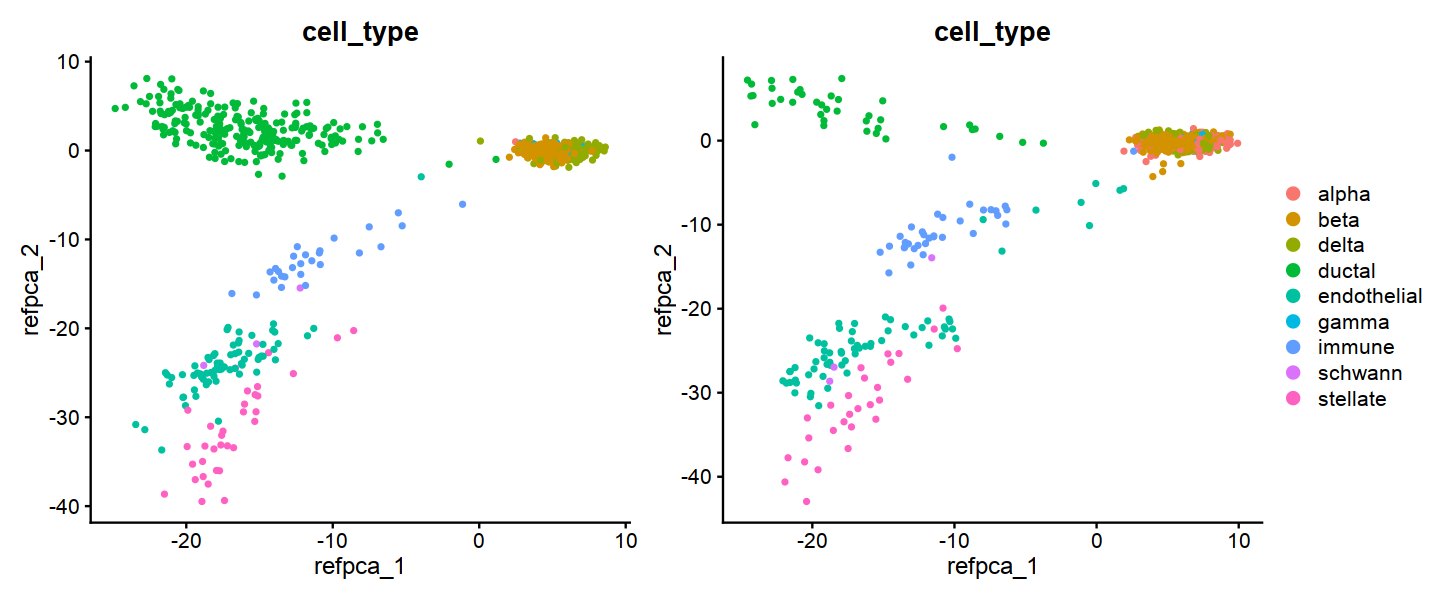

In [36]:
# Now that mapping is complete, we can visualize the results for individual objects

options(repr.plot.height = 5, repr.plot.width = 12)
p1 <- DimPlot(panc_query.batches[[1]], reduction = 'ref.pca', group.by = 'cell_type', label.size = 3)
p2 <- DimPlot(panc_query.batches[[2]], reduction = 'ref.pca', group.by = 'cell_type', label.size = 3)
p1 + p2 + plot_layout(guides = "collect")

In [37]:
# Merge the batches 
panc_query <- merge(panc_query.batches[[1]], panc_query.batches[2:length(panc_query.batches)], merge.dr = "ref.pca")

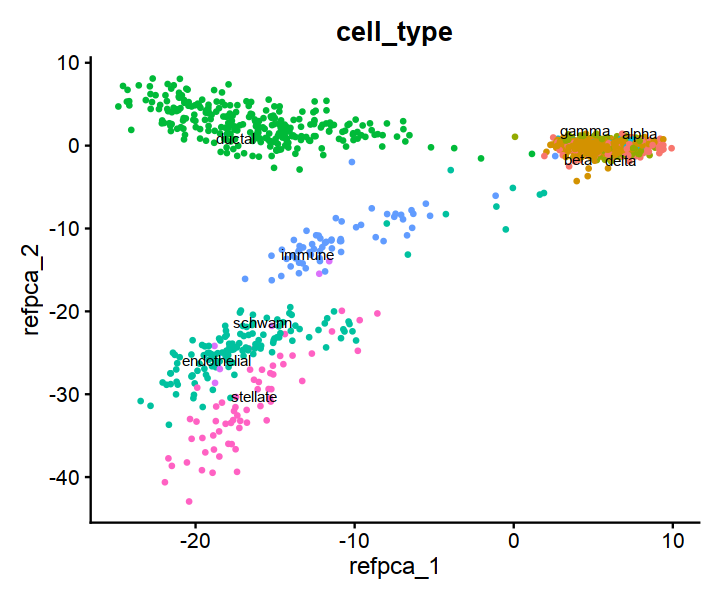

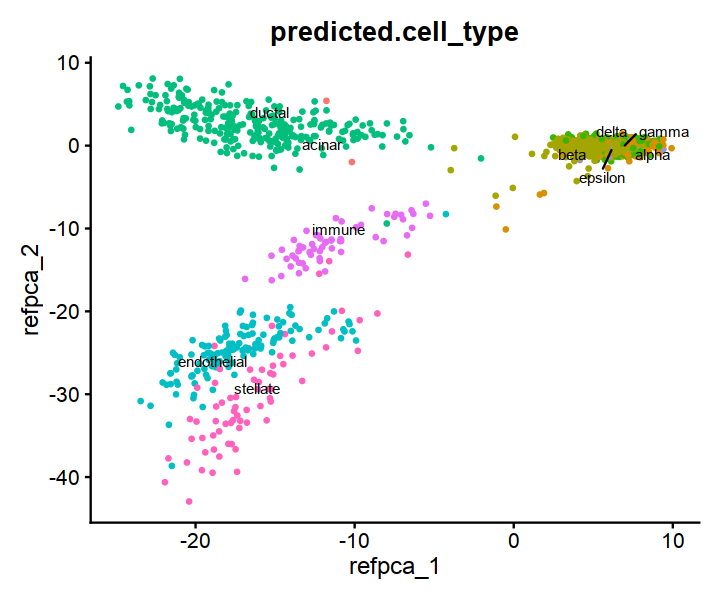

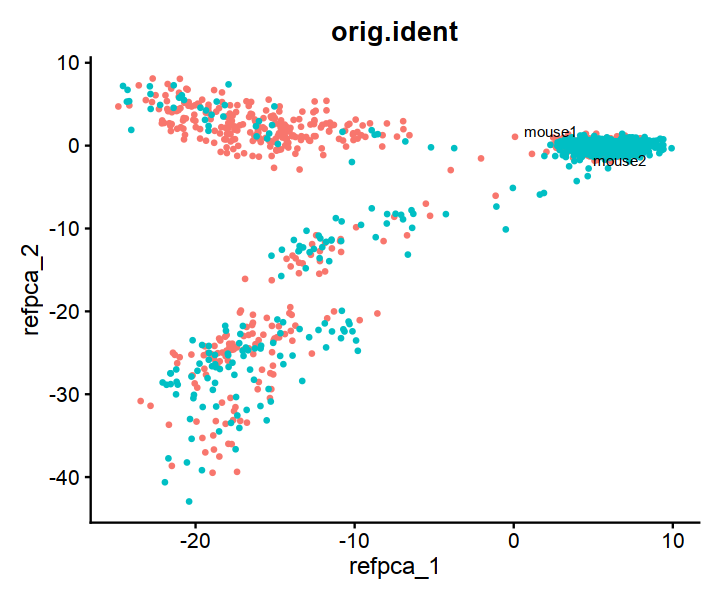

In [38]:
options(repr.plot.height = 5, repr.plot.width = 6)
DimPlot(panc_query, reduction = "ref.pca", group.by =  "cell_type", label = TRUE, repel = TRUE, label.size = 3) + NoLegend()
DimPlot(panc_query, reduction = "ref.pca", group.by =  "predicted.cell_type", label = TRUE, repel = TRUE, label.size = 3) + NoLegend()
DimPlot(panc_query, reduction = "ref.pca", group.by =  "orig.ident", label = TRUE, repel = TRUE, label.size = 3) + NoLegend()

In [42]:
saveRDS(panc_query, "Seurat_query_mouse_obj.rds")

In [43]:
panc_query

An object of class Seurat 
1884 features across 1886 samples within 2 assays 
Active assay: RNA (1874 features, 0 variable features)
 1 other assay present: prediction.score.cell_type
 1 dimensional reduction calculated: ref.pca

# Load embeddings from Seurat object

In [44]:
ref <- readRDS("Seurat_reference_obj.rds")
human <- readRDS("Seurat_query_human_obj.rds")
mouse <- readRDS("Seurat_query_mouse_obj.rds")

In [45]:
ref <- Embeddings(ref, reduction = "pca")
dim(ref)

human <- Embeddings(human, reduction = "ref.pca")
dim(human)

mouse <- Embeddings(mouse, reduction = "ref.pca")
dim(mouse)

[1] 5887   20

[1] 8569   20

[1] 1886   20

In [46]:
all <- rbind(ref[, 1:20], human[, 1:20], mouse[, 1:20])
all <- as.data.frame(all)
all$dataset <- c(rep("ref", nrow(ref)), 
                 rep("human_query", nrow(human)), 
                 rep("mouse_query", nrow(mouse)))
all[1:4,]
saveRDS(all, "Seurat_mapping_embedding_ref_human_mouse.rds")

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,⋯,PC_12,PC_13,PC_14,PC_15,PC_16,PC_17,PC_18,PC_19,PC_20,dataset
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
celseq_D2ex_1,-12.58674,5.790013,15.99485,-1.517400,-3.001803,-0.20944218,-0.3137077,1.446285,0.9885248,0.3486142,⋯,-3.2358565,-0.78976632,0.29671547,1.901994,-0.3485649,3.6513465,-2.1889576,-1.9300381,-5.666620,ref
celseq_D2ex_2,-14.31100,5.067452,15.95829,-1.339036,-2.134020,0.08023112,0.0723102,-5.221388,-1.4758526,0.4937311,⋯,3.6454237,-1.42544825,1.56575738,2.656338,-1.7725170,0.8624460,-1.0064895,-2.0392383,-2.582120,ref
celseq_D2ex_3,-12.18049,6.670549,16.88024,-1.266596,-2.638018,-0.41751752,2.5003162,-3.312074,-0.9163369,1.7307375,⋯,0.2865497,0.05970003,2.66984011,1.865040,-2.4693331,0.7626056,-0.8286385,2.0387863,2.024411,ref
celseq_D2ex_4,-25.25817,8.943583,-12.88182,2.162774,2.335063,-1.85979364,-0.9725330,-8.549531,-5.0946365,3.3925643,⋯,0.9381636,0.45748911,0.01561074,3.430193,-0.1370042,-2.1164241,-0.4785393,0.4378673,-3.687884,ref


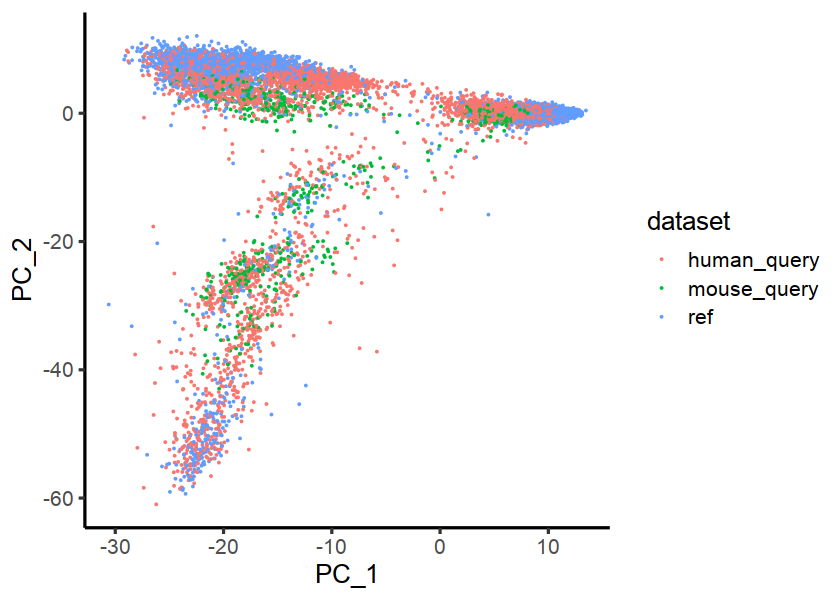

In [47]:
options(repr.plot.height = 5, repr.plot.width = 7)
ggplot() +
  geom_point(
    data = all[sample(nrow(all)),],
    mapping = aes_string(x = "PC_1", y = "PC_2", fill = "dataset"),
    size = 0.8, stroke = 0.001, shape = 21
  ) +
#   scale_fill_manual(values = meta_colors$cluster, name = "") +
    theme_classic(base_size = 15) +
    theme(
      panel.grid = element_blank()
    )

In [48]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/jbk37/anaconda3/envs/seurat4/lib/libopenblasp-r0.3.15.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] matrixStats_0.59.0 patchwork_1.1.1    RColorBrewer_1.1-2 ggthemes_4.2.4    
[5] ggplot2_3.3.4      uwot_0.1.10        Matrix_1.3-3       SeuratObject_4.0.1
[9] Seurat_4.0.2      

loaded via a namespace (and not attached):
  [1] nlme_3.1-152          spatstat.sp